### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from neuralforecast.models import DeepAR
from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

In [ ]:
# To load local csv  > modify to the right path where the file is present
#AirPassengersPanel = pd.read_csv('AirPassengersPanel.csv')
#AirPassengersPanel = AirPassengersPanel.reset_index(drop=True)
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic
AirPassengersPanel

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0
...,...,...,...,...,...
283,Airline2,1960-08-31,906.0,283,859.0
284,Airline2,1960-09-30,808.0,284,763.0
285,Airline2,1960-10-31,761.0,285,707.0
286,Airline2,1960-11-30,690.0,286,662.0


In [ ]:
AirPassengersStatic

,unique_id,airline1,airline2
0,Airline1,0,1
1,Airline2,1,0


Load **AirPassenger** data set and split data into **train** and **test**

In [ ]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 training data
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test data


Lets initialize and training model (**DeepAR**) and define its hyperparameters.

In [ ]:
nf = NeuralForecast(
    models=[DeepAR(h=12,
                   input_size=48,
                   lstm_n_layers=3,
                   trajectory_samples=100,
                   loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=False),
                   learning_rate=0.005,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'],
                   max_steps=100,
                   val_check_steps=10,
                   early_stop_patience_steps=-1,
                   scaler_type='standard',
                   enable_progress_bar=True),
    ],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MQLoss           | 5      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 332 K  | train
5 | decoder      | Decoder          | 258    | train
----------------------------------------------------------
332 K     Trainable params
10        Non-trainable params
332 K     Total params
1.330     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


Predict for the next defined horizon

In [ ]:
Y_hat_df = nf.predict(futr_df=Y_test_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
Y_hat_df

,ds,DeepAR,DeepAR-median,DeepAR-lo-90,DeepAR-lo-80,DeepAR-hi-80,DeepAR-hi-90
unique_id,,,,,,,
Airline1,1960-01-31,415.200775,413.846069,385.291718,394.683624,443.522583,454.160156
Airline1,1960-02-29,431.533722,431.639160,394.706299,401.953308,460.426178,467.867493
Airline1,1960-03-31,437.992218,439.715088,395.064148,407.487457,467.977692,476.772095
Airline1,1960-04-30,446.789795,447.080872,406.911774,415.343719,473.718048,484.828094
Airline1,1960-05-31,464.116455,466.025696,424.759277,433.739288,491.210815,497.137115
Airline1,1960-06-30,517.927979,520.244934,478.387085,489.869629,543.724243,551.895020
Airline1,1960-07-31,592.453186,592.224854,566.327087,569.871155,618.080872,623.083252
Airline1,1960-08-31,573.759155,575.742676,540.511108,550.388977,598.031006,605.226501
Airline1,1960-09-30,498.683350,498.798462,470.481232,480.090973,520.804504,523.591736


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],Y_hat_df[['DeepAR']])

MSE : 455.6470642089844
RMSE : 21.34589195251465
MAPE : 0.02916746586561203
r2 : 0.9837497995847083
adjusted_r2 : 0.9830111541112859


Visualize the predictions

[]

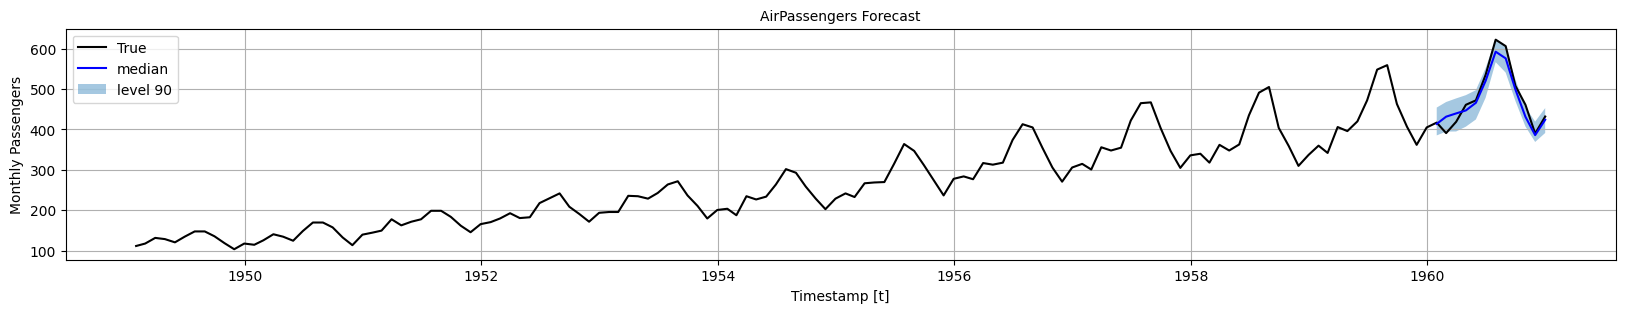

In [ ]:
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])
plt.figure(figsize=(20, 3))
plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
#plt.plot(plot_df['ds'], plot_df['DeepAR'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['DeepAR-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['DeepAR-lo-90'][-12:].values,
                 y2=plot_df['DeepAR-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.legend()
plt.grid()
plt.plot()